In [1]:

%load_ext autoreload
%autoreload 2
from rioplatense_hs.openai import get_completion
import pandas as pd
from glob import glob
pd.options.display.max_colwidth = 1000
#df_train.loc[df_train["LGBTI"] > 0, ["title", "text", "text_label"]].sample(20)

few_shot_files = sorted(glob("../data/test*pred.csv"))
one_shot_files = sorted(glob("../data/test*pred*1shot.csv"))
beto_files = sorted(glob("../data/test*beto.csv"))

assert len(few_shot_files) == len(one_shot_files) == len(beto_files)

dfs = {
    "one-shot": pd.concat([pd.read_csv(f, index_col=0) for f in one_shot_files]),
    "few-shot": pd.concat([pd.read_csv(f, index_col=0) for f in few_shot_files]),
    "beto": pd.concat([pd.read_csv(f, index_col=0) for f in beto_files]),
}


In [2]:
assert all(dfs["few-shot"].index == dfs["one-shot"].index)
assert all(dfs["few-shot"].index == dfs["beto"].index)

## Error analysis

In [3]:
from rioplatense_hs.preprocessing import text_to_label, labels
from sklearn.metrics import classification_report

pred_labels = [f"PRED_{label}" for label in labels]

dfs["beto"][pred_labels] = (dfs["beto"][pred_labels] > 0.5).astype(int)

In [4]:
from tqdm.auto import tqdm
from confidence_intervals import Bootstrap
from sklearn.metrics import precision_score, recall_score, f1_score

metrics = []

for name, df in dfs.items():
    print(name)
    for label in tqdm(labels):

        for metric in {"precision", "recall", "f1"}:
            if metric == "precision":
                score = precision_score
            elif metric == "recall":
                score = recall_score
            elif metric == "f1":
                score = f1_score


            gold_labels = df[label].values
            preds = df[f"PRED_{label}"].values

            bst = Bootstrap(metric=score)

            bst_scores = bst.run(preds, gold_labels)

            for score in bst_scores:
                metrics.append(
                    {
                        "model": name,
                        "label": label,
                        "metric": metric,
                        "score": score,
                    }
                )


one-shot


  0%|          | 0/8 [00:00<?, ?it/s]

few-shot


  0%|          | 0/8 [00:00<?, ?it/s]

beto


  0%|          | 0/8 [00:00<?, ?it/s]

In [5]:
df_metrics = pd.DataFrame(metrics)

df_metrics

,model,label,metric,score
0,one-shot,WOMEN,recall,0.283871
1,one-shot,WOMEN,recall,0.301471
2,one-shot,WOMEN,recall,0.278689
3,one-shot,WOMEN,recall,0.301587
4,one-shot,WOMEN,recall,0.309859
...,...,...,...,...
71995,beto,CRIMINAL,f1,0.687117
71996,beto,CRIMINAL,f1,0.684564
71997,beto,CRIMINAL,f1,0.689655
71998,beto,CRIMINAL,f1,0.695122


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'WOMEN'),
  Text(1, 0, 'LGBTI'),
  Text(2, 0, 'RACISM'),
  Text(3, 0, 'CLASS'),
  Text(4, 0, 'POLITICS'),
  Text(5, 0, 'DISABLED'),
  Text(6, 0, 'APPEARANCE'),
  Text(7, 0, 'CRIMINAL')])

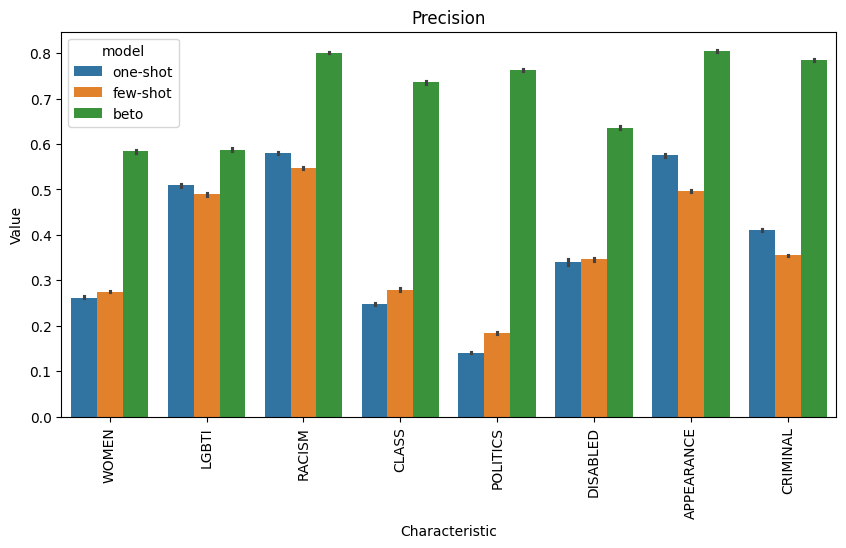

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create the barplot

metric = "precision"

plt.figure(figsize=(10, 5))
sns.barplot(x='label', y='score', hue='model', data=df_metrics[df_metrics["metric"] == metric], hue_order=["one-shot", "few-shot", "beto"])


# Set the plot title and labels
plt.title('Precision')
plt.xlabel('Characteristic')
plt.ylabel('Value')

# Show the plot

plt.xticks(rotation=90)
#plt.show()

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'WOMEN'),
  Text(1, 0, 'LGBTI'),
  Text(2, 0, 'RACISM'),
  Text(3, 0, 'CLASS'),
  Text(4, 0, 'POLITICS'),
  Text(5, 0, 'DISABLED'),
  Text(6, 0, 'APPEARANCE'),
  Text(7, 0, 'CRIMINAL')])

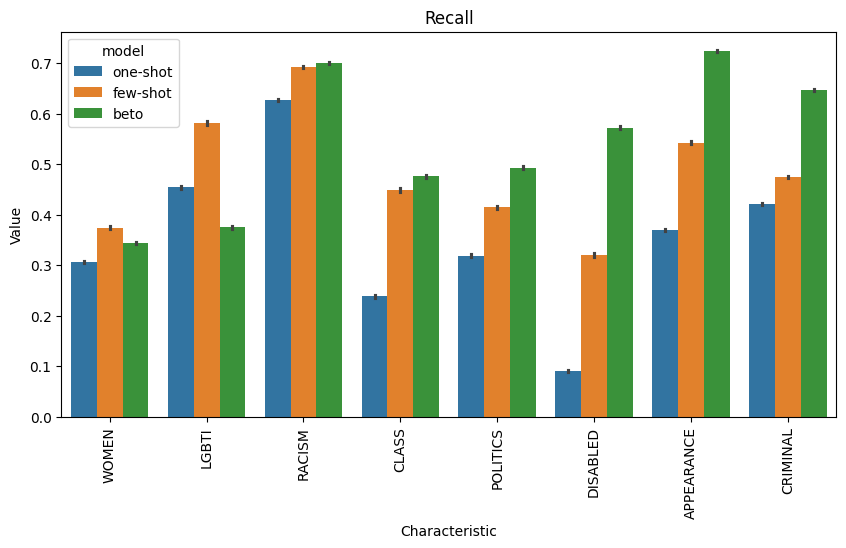

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create the barplot

metric = "recall"

plt.figure(figsize=(10, 5))
sns.barplot(x='label', y='score', hue='model', data=df_metrics[df_metrics["metric"] == metric], hue_order=["one-shot", "few-shot", "beto"])


# Set the plot title and labels
plt.title(metric.capitalize())
plt.xlabel('Characteristic')
plt.ylabel('Value')

# Show the plot

plt.xticks(rotation=90)
#plt.show()

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'WOMEN'),
  Text(1, 0, 'LGBTI'),
  Text(2, 0, 'RACISM'),
  Text(3, 0, 'CLASS'),
  Text(4, 0, 'POLITICS'),
  Text(5, 0, 'DISABLED'),
  Text(6, 0, 'APPEARANCE'),
  Text(7, 0, 'CRIMINAL')])

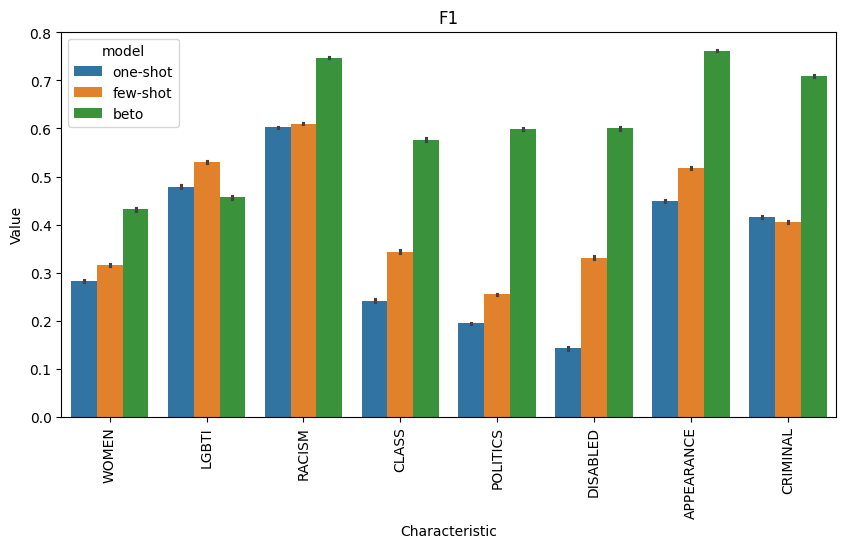

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create the barplot

metric = "f1"

plt.figure(figsize=(10, 5))
sns.barplot(x='label', y='score', hue='model', data=df_metrics[df_metrics["metric"] == metric], hue_order=["one-shot", "few-shot", "beto"])


# Set the plot title and labels
plt.title(metric.capitalize())
plt.xlabel('Characteristic')
plt.ylabel('Value')

# Show the plot

plt.xticks(rotation=90)
#plt.show()

In [15]:
# Just keep the most important characteristics
core_labels = ["WOMEN", "LGBTI", "RACISM", "CLASS"]
pred_core_labels = [f"PRED_{label}" for label in core_labels]

hate_metrics = []


for name, df in dfs.items():
    label_core_hate = df[core_labels].sum(axis=1) > 0
    pred_core_hate = df[pred_core_labels].sum(axis=1) > 0

    for metric in {"precision", "recall", "f1"}:
        if metric == "precision":
            score = precision_score
        elif metric == "recall":
            score = recall_score
        elif metric == "f1":
            score = f1_score


        gold_labels = label_core_hate.values
        preds = pred_core_hate.values

        bst = Bootstrap(metric=score)

        bst_scores = bst.run(preds, gold_labels)

        for score in bst_scores:
            hate_metrics.append(
                {
                    "model": name,
                    "metric": metric,
                    "score": score,
                }
            )

hate_metrics = pd.DataFrame(hate_metrics)

hate_metrics

,model,metric,score
0,one-shot,recall,0.540881
1,one-shot,recall,0.522267
2,one-shot,recall,0.484407
3,one-shot,recall,0.516556
4,one-shot,recall,0.513238
...,...,...,...
8995,beto,f1,0.618705
8996,beto,f1,0.634921
8997,beto,f1,0.638398
8998,beto,f1,0.638498


([0, 1, 2], [Text(0, 0, 'recall'), Text(1, 0, 'precision'), Text(2, 0, 'f1')])

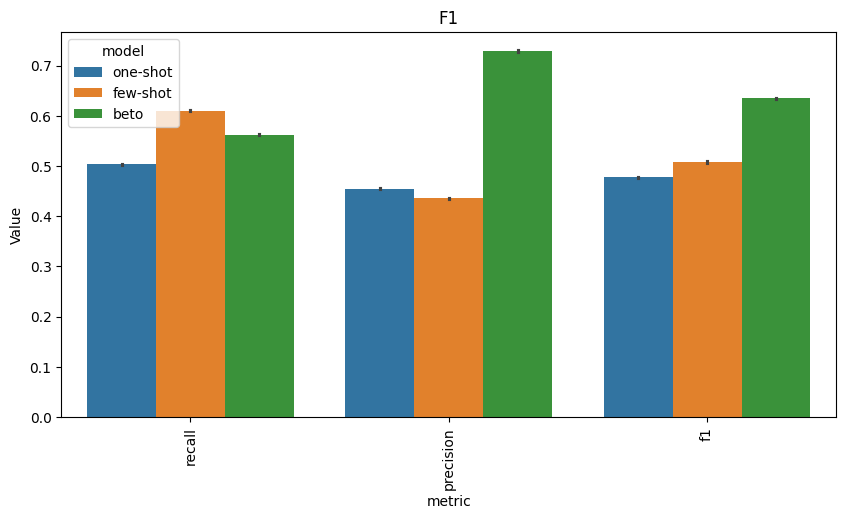

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create the barplot

plt.figure(figsize=(10, 5))
sns.barplot(x='metric', y='score', hue='model', data=hate_metrics, hue_order=["one-shot", "few-shot", "beto"])


# Set the plot title and labels
plt.title(metric.capitalize())
plt.ylabel('Value')

# Show the plot

plt.xticks(rotation=90)
#plt.show()

In [ ]:
pd.options.display.max_colwidth = 1000

df_test[pred_core_hate != label_core_hate][["context_tweet", "text", "pred_cot", ]].sample(5)

In [ ]:
pd.options.display.max_colwidth = 1000

df_test[pred_core_hate != label_core_hate][["context_tweet", "text", "pred_cot", ]].sample(200).to_csv("../data/errors.csv")

In [ ]:
# LGBTI errors

label = "LGBTI"
df_test.loc[df_test[label] != df_test[f"PRED_{label}"]][["context_tweet", "text", "pred_cot"]].sample(5)

In [ ]:
df_train[(df_train["POLITICS"] > 0) & (df_train["num_hatred"] > 1)][["context_tweet", "text", "text_label"]].sample(5)

In [ ]:
sample_df["PRED_HATEFUL"] = pred_hate.astype(int)

In [ ]:
sample_df.to_csv("../data/sample_dev_df.csv", index=False)